# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Like MLP_243. Tail exclusion in validate.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 17:19:25.542453


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_255' 

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 17:19:59.569388
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 17:20:00.647765
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 17:20:14.247426
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 17:20:14.625420
Discriminator ZERO -1
Train 1:0 1659:1837 47.45%
Valid 1:0 174:162 51.79%
FIT
2023-04-09 17:20:14.737322


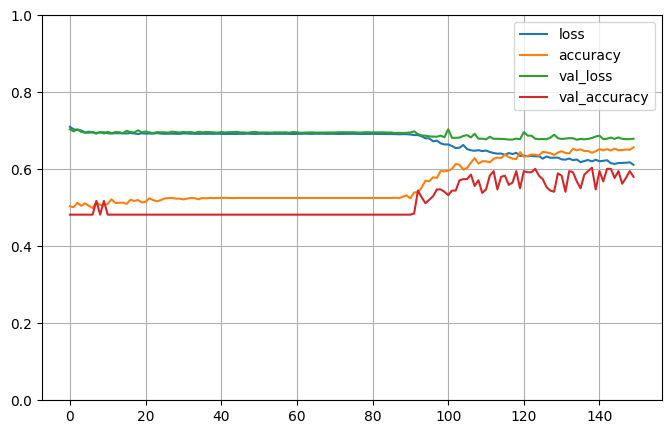


Testing # 1 1
2023-04-09 17:21:45.546046
2023-04-09 17:21:45.546544
PREDICT
2023-04-09 17:21:45.565616
Test 1:0 174:162 51.79%
Predict 1:0 225:111 66.96%
Test sizes (336, 1025) (336,)
Distrib of scores: 0.5387561 mean 0.15205307 std
Range of scores: 0.08226694 to 0.76928806
Score threshold 0.5
Confusion matrix
 [[ 66  96]
 [ 45 129]]
Normalized matrix
 [[0.19642857 0.28571429]
 [0.13392857 0.38392857]]
Extreme scores correct, pos:neg 61 23
Extreme scores incorrect pos:neg 29 20


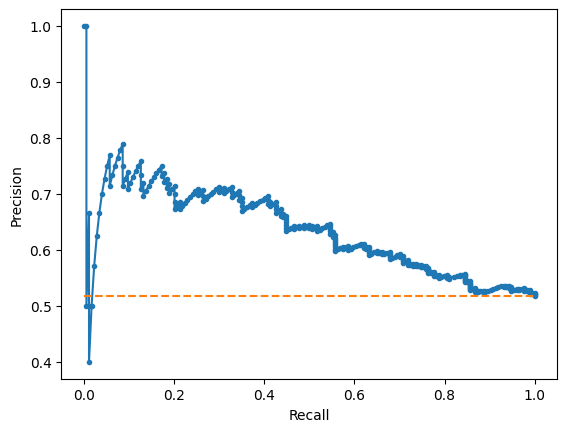

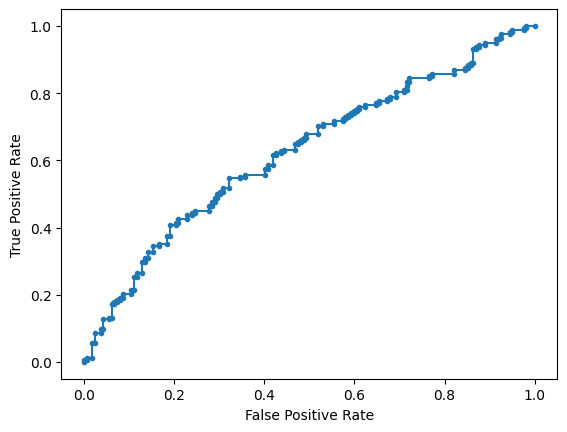

Accuracy: 58.04% Precision: 57.33% Recall: 74.14%
F1: 64.66% MCC: 0.1581
AUPRC: 63.32% AUROC: 62.49%
 accuracy [58.03571428571429]
 precision [57.333333333333336]
 recall [74.13793103448276]
 F1 [64.66165413533834]
 MCC [0.158067850037034]
 AUPRC [63.31556904675273]
 AUROC [62.49467858663261]

Training # 1 2
2023-04-09 17:21:48.555291
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 17:21:48.942174
Discriminator ZERO -1
Train 1:0 1643:1853 47.00%
Valid 1:0 177:152 53.80%
FIT
2023-04-09 17:21:49.084425


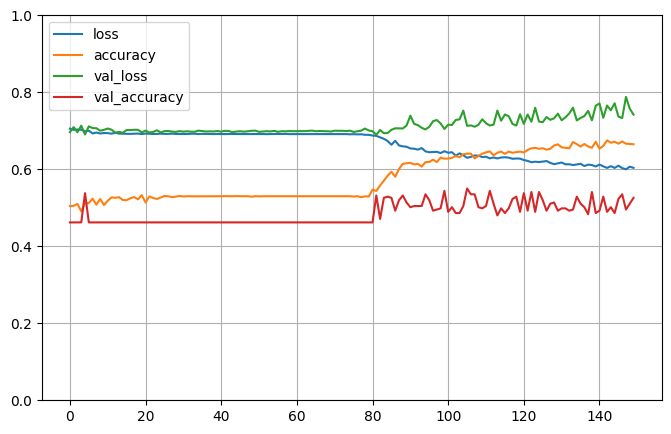


Testing # 1 2
2023-04-09 17:23:18.982533
2023-04-09 17:23:18.982980
PREDICT
2023-04-09 17:23:18.987754
Test 1:0 177:152 53.80%
Predict 1:0 189:140 57.45%
Test sizes (329, 1025) (329,)
Distrib of scores: 0.51270694 mean 0.16599466 std
Range of scores: 0.07152902 to 0.8307916
Score threshold 0.5
Confusion matrix
 [[ 68  84]
 [ 72 105]]
Normalized matrix
 [[0.20668693 0.25531915]
 [0.21884498 0.31914894]]
Extreme scores correct, pos:neg 42 31
Extreme scores incorrect pos:neg 34 27


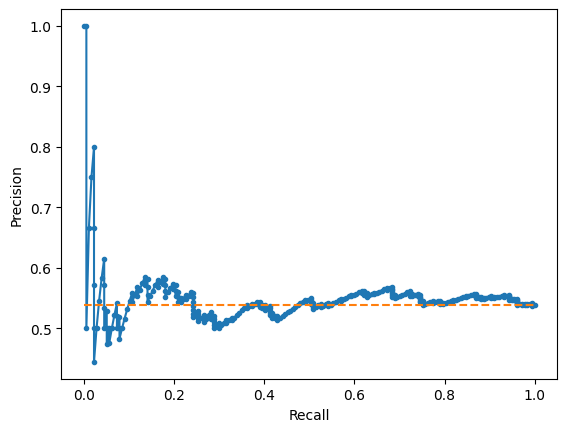

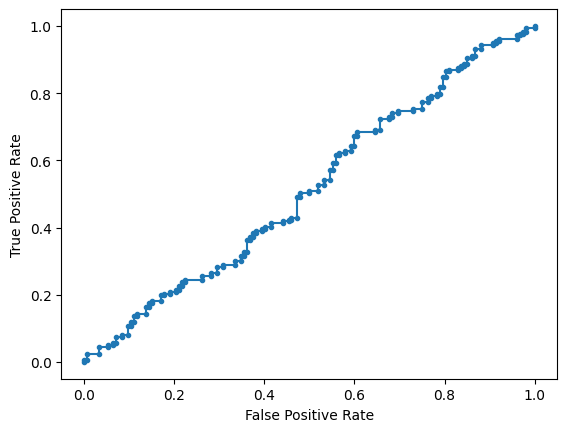

Accuracy: 52.58% Precision: 55.56% Recall: 59.32%
F1: 57.38% MCC: 0.0409
AUPRC: 54.76% AUROC: 51.43%
 accuracy [52.58358662613982]
 precision [55.55555555555556]
 recall [59.32203389830508]
 F1 [57.377049180327866]
 MCC [0.04092788394251883]
 AUPRC [54.76355802544172]
 AUROC [51.42729705619982]

Training # 1 3
2023-04-09 17:23:19.607346
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 17:23:19.985703
Discriminator ZERO -1
Train 1:0 1671:1826 47.78%
Valid 1:0 174:181 49.01%
FIT
2023-04-09 17:23:20.077669


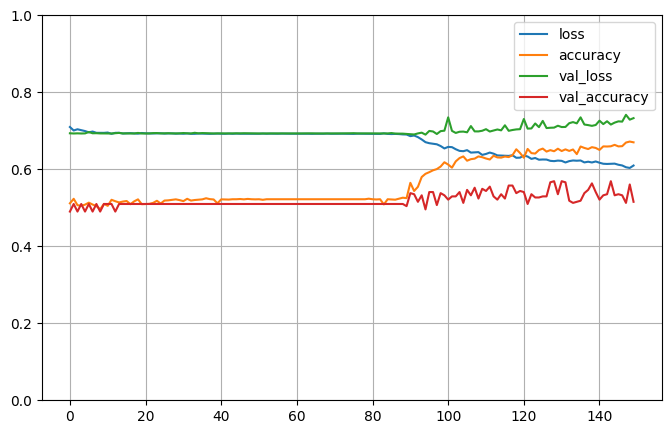


Testing # 1 3
2023-04-09 17:25:43.384274
2023-04-09 17:25:43.384331
PREDICT
2023-04-09 17:25:43.391783
Test 1:0 174:181 49.01%
Predict 1:0 134:221 37.75%
Test sizes (355, 1025) (355,)
Distrib of scores: 0.43760964 mean 0.17234226 std
Range of scores: 0.044316437 to 0.8131399
Score threshold 0.5
Confusion matrix
 [[115  66]
 [106  68]]
Normalized matrix
 [[0.32394366 0.18591549]
 [0.29859155 0.1915493 ]]
Extreme scores correct, pos:neg 22 65
Extreme scores incorrect pos:neg 21 48


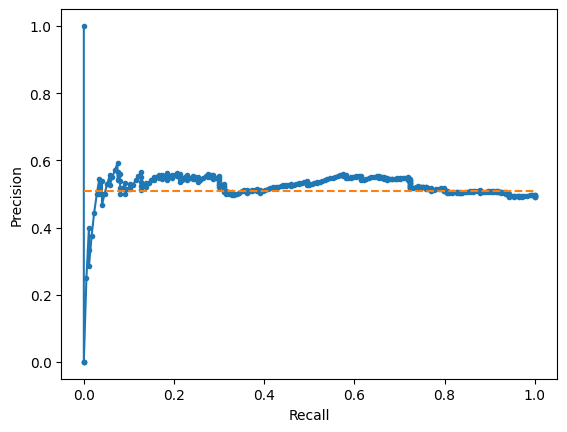

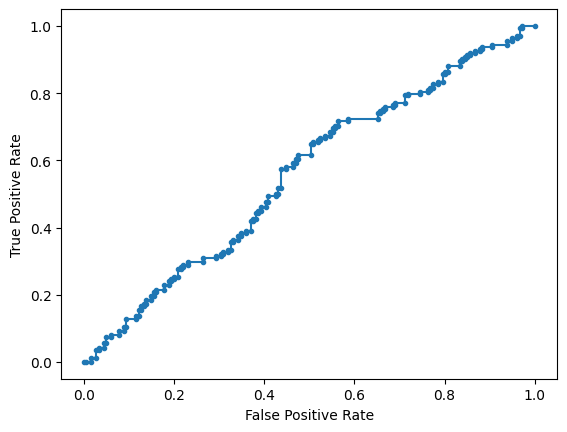

Accuracy: 51.55% Precision: 50.75% Recall: 39.08%
F1: 44.16% MCC: 0.0270
AUPRC: 52.17% AUROC: 55.86%
 accuracy [51.54929577464789]
 precision [50.74626865671642]
 recall [39.08045977011494]
 F1 [44.15584415584416]
 MCC [0.026981417624111638]
 AUPRC [52.16981106921557]
 AUROC [55.86143392392201]

Training # 1 4
2023-04-09 17:25:44.053464
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 17:25:44.378231
Discriminator ZERO -1
Train 1:0 1637:1860 46.81%
Valid 1:0 193:166 53.76%
FIT
2023-04-09 17:25:44.479647


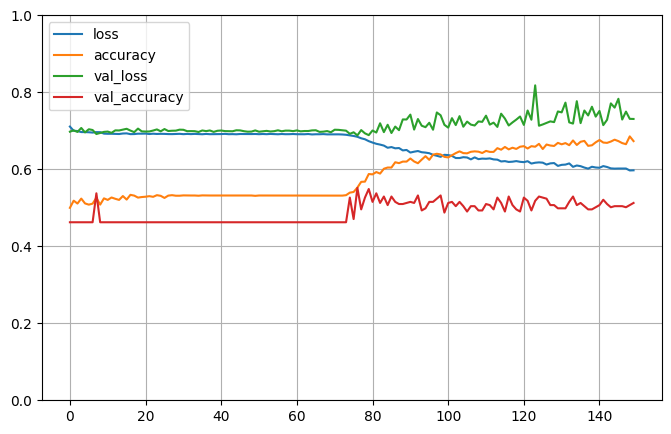


Testing # 1 4
2023-04-09 17:27:15.179134
2023-04-09 17:27:15.179193
PREDICT
2023-04-09 17:27:15.184829
Test 1:0 193:166 53.76%
Predict 1:0 222:137 61.84%
Test sizes (359, 1025) (359,)
Distrib of scores: 0.5271138 mean 0.17601414 std
Range of scores: 0.0025140594 to 0.80243284
Score threshold 0.5
Confusion matrix
 [[ 64 102]
 [ 73 120]]
Normalized matrix
 [[0.17827298 0.28412256]
 [0.20334262 0.33426184]]
Extreme scores correct, pos:neg 60 40
Extreme scores incorrect pos:neg 44 24


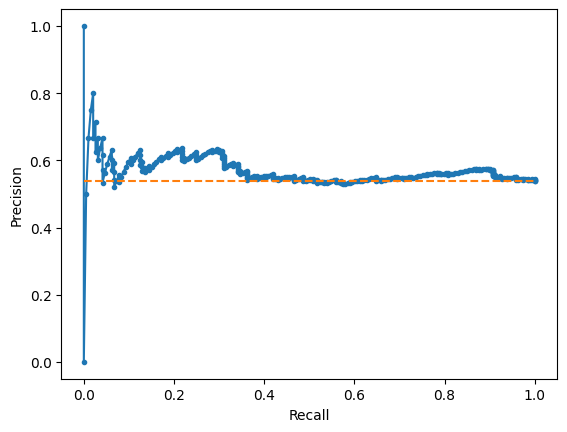

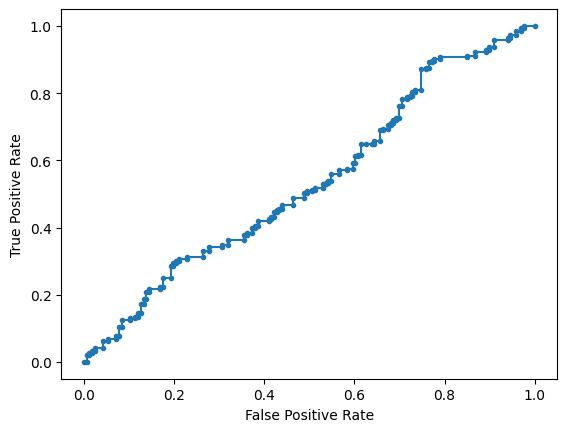

Accuracy: 51.25% Precision: 54.05% Recall: 62.18%
F1: 57.83% MCC: 0.0075
AUPRC: 56.75% AUROC: 53.68%
 accuracy [51.25348189415042]
 precision [54.054054054054056]
 recall [62.17616580310881]
 F1 [57.83132530120483]
 MCC [0.007496290152708738]
 AUPRC [56.75193829347962]
 AUROC [53.683126287533554]

Training # 1 5
2023-04-09 17:27:15.778428
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 17:27:16.105647
Discriminator ZERO -1
Train 1:0 1634:1864 46.71%
Valid 1:0 176:163 51.92%
FIT
2023-04-09 17:27:16.194707


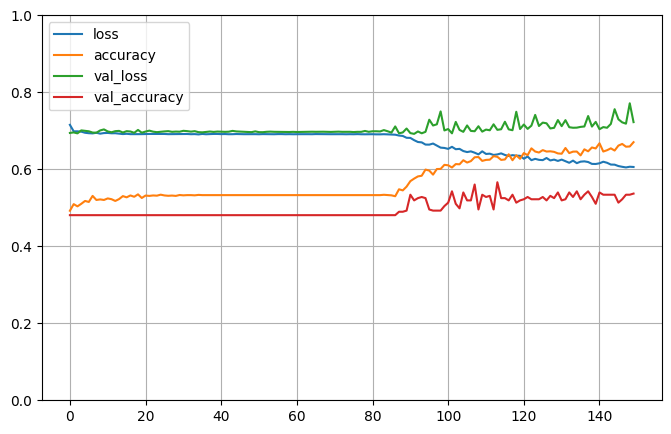


Testing # 1 5
2023-04-09 17:28:48.576017
2023-04-09 17:28:48.576109
PREDICT
2023-04-09 17:28:48.581324
Test 1:0 176:163 51.92%
Predict 1:0 171:168 50.44%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.5008725 mean 0.16276981 std
Range of scores: 0.04335549 to 0.8376759
Score threshold 0.5
Confusion matrix
 [[87 76]
 [81 95]]
Normalized matrix
 [[0.25663717 0.22418879]
 [0.23893805 0.28023599]]
Extreme scores correct, pos:neg 44 35
Extreme scores incorrect pos:neg 26 30


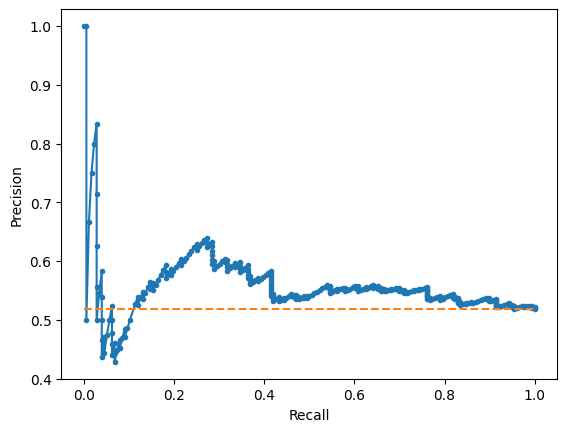

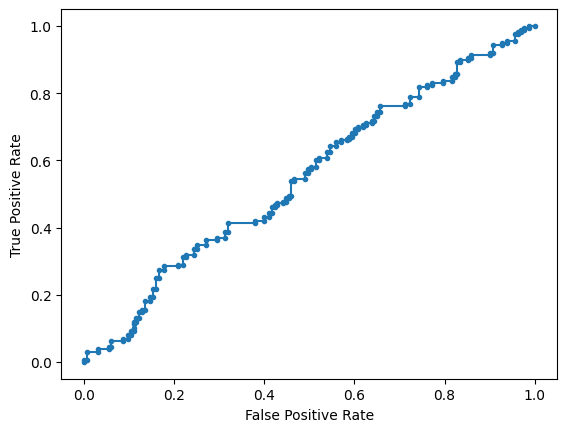

Accuracy: 53.69% Precision: 55.56% Recall: 53.98%
F1: 54.76% MCC: 0.0735
AUPRC: 55.67% AUROC: 55.07%
 accuracy [53.687315634218294]
 precision [55.55555555555556]
 recall [53.97727272727273]
 F1 [54.75504322766571]
 MCC [0.07346386065907343]
 AUPRC [55.672601719443215]
 AUROC [55.071807027328504]

Training # 2 1
2023-04-09 17:28:49.266726
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 17:28:49.609129
Discriminator ZERO -1
Train 1:0 1655:1841 47.34%
Valid 1:0 180:170 51.43%
FIT
2023-04-09 17:28:49.708146


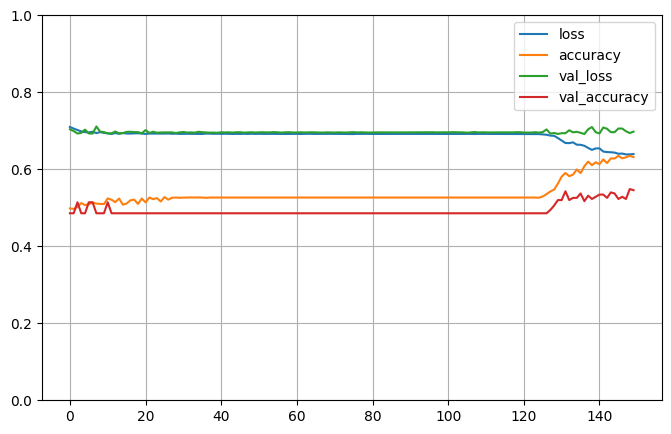


Testing # 2 1
2023-04-09 17:30:18.044270
2023-04-09 17:30:18.044766
PREDICT
2023-04-09 17:30:18.053599
Test 1:0 180:170 51.43%
Predict 1:0 177:173 50.57%
Test sizes (350, 1025) (350,)
Distrib of scores: 0.49834377 mean 0.13175009 std
Range of scores: 0.1550004 to 0.79878265
Score threshold 0.5
Confusion matrix
 [[92 78]
 [81 99]]
Normalized matrix
 [[0.26285714 0.22285714]
 [0.23142857 0.28285714]]
Extreme scores correct, pos:neg 28 29
Extreme scores incorrect pos:neg 19 23


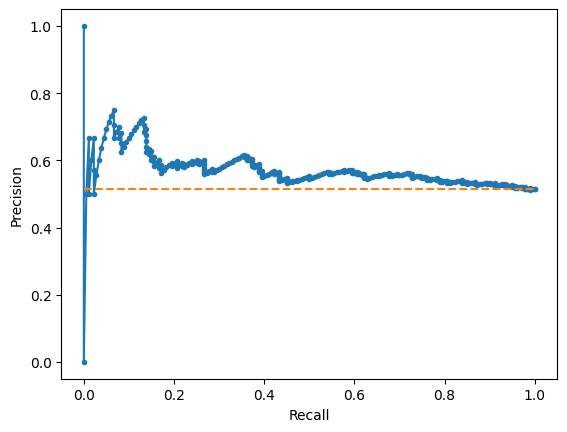

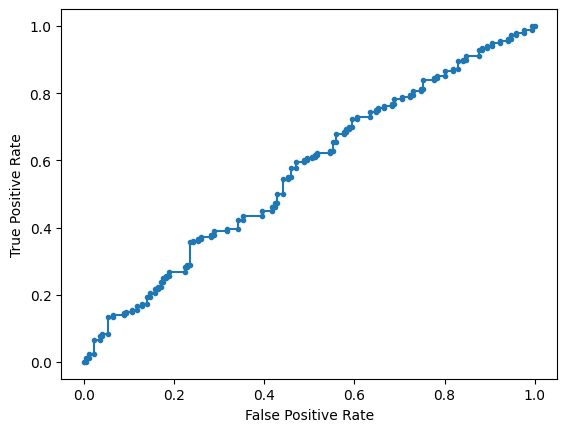

Accuracy: 54.57% Precision: 55.93% Recall: 55.00%
F1: 55.46% MCC: 0.0911
AUPRC: 57.02% AUROC: 56.69%
 accuracy [54.57142857142857]
 precision [55.932203389830505]
 recall [55.00000000000001]
 F1 [55.462184873949575]
 MCC [0.09114520063831302]
 AUPRC [57.01803139920707]
 AUROC [56.68954248366013]

Training # 2 2
2023-04-09 17:30:18.640621
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 17:30:18.968543
Discriminator ZERO -1
Train 1:0 1645:1851 47.05%
Valid 1:0 178:162 52.35%
FIT
2023-04-09 17:30:19.071300


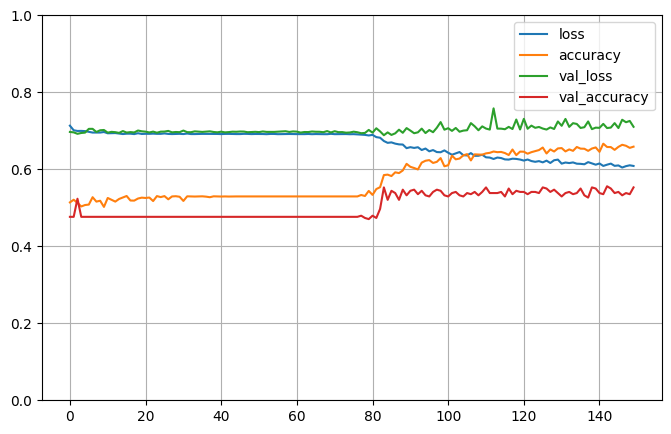


Testing # 2 2
2023-04-09 17:31:47.848241
2023-04-09 17:31:47.848737
PREDICT
2023-04-09 17:31:47.857719
Test 1:0 178:162 52.35%
Predict 1:0 226:114 66.47%
Test sizes (340, 1025) (340,)
Distrib of scores: 0.5399671 mean 0.14833702 std
Range of scores: 0.09603174 to 0.7867873
Score threshold 0.5
Confusion matrix
 [[ 62 100]
 [ 52 126]]
Normalized matrix
 [[0.18235294 0.29411765]
 [0.15294118 0.37058824]]
Extreme scores correct, pos:neg 55 27
Extreme scores incorrect pos:neg 41 21


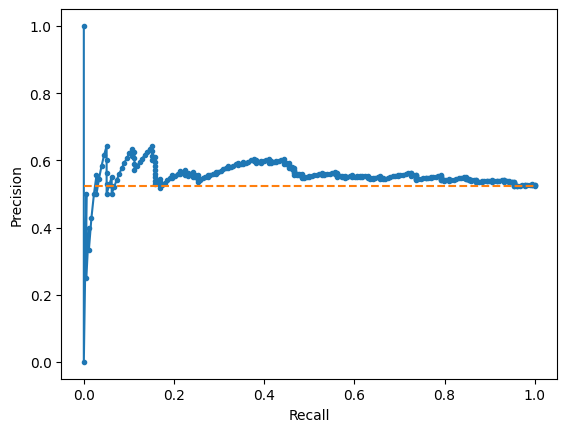

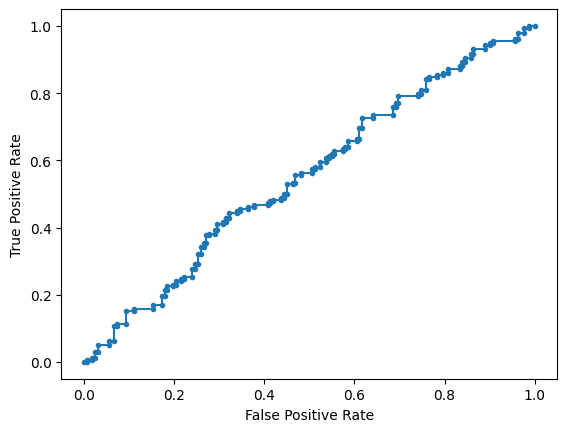

Accuracy: 55.29% Precision: 55.75% Recall: 70.79%
F1: 62.38% MCC: 0.0958
AUPRC: 55.50% AUROC: 55.36%
 accuracy [55.294117647058826]
 precision [55.75221238938053]
 recall [70.78651685393258]
 F1 [62.376237623762364]
 MCC [0.09582945515310388]
 AUPRC [55.49835180414656]
 AUROC [55.35788597586351]

Training # 2 3
2023-04-09 17:31:48.822173
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 17:31:49.187880
Discriminator ZERO -1
Train 1:0 1634:1863 46.73%
Valid 1:0 184:159 53.64%
FIT
2023-04-09 17:31:49.347095


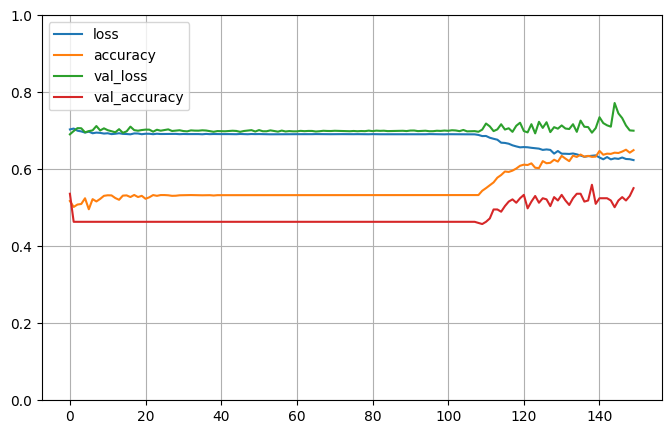


Testing # 2 3
2023-04-09 17:34:13.506166
2023-04-09 17:34:13.506584
PREDICT
2023-04-09 17:34:13.511808
Test 1:0 184:159 53.64%
Predict 1:0 206:137 60.06%
Test sizes (343, 1025) (343,)
Distrib of scores: 0.5280426 mean 0.13391303 std
Range of scores: 0.17976424 to 0.7785904
Score threshold 0.5
Confusion matrix
 [[ 71  88]
 [ 66 118]]
Normalized matrix
 [[0.20699708 0.25655977]
 [0.19241983 0.34402332]]
Extreme scores correct, pos:neg 44 21
Extreme scores incorrect pos:neg 30 16


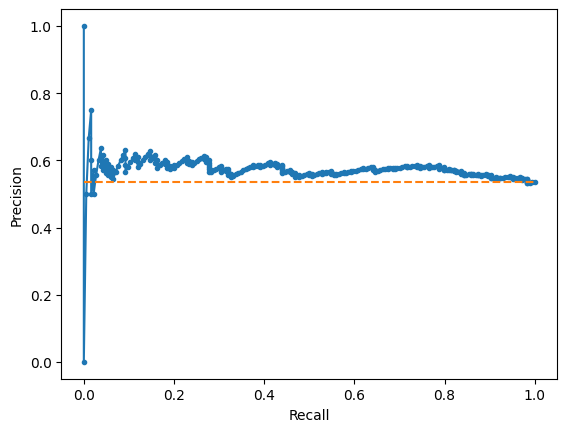

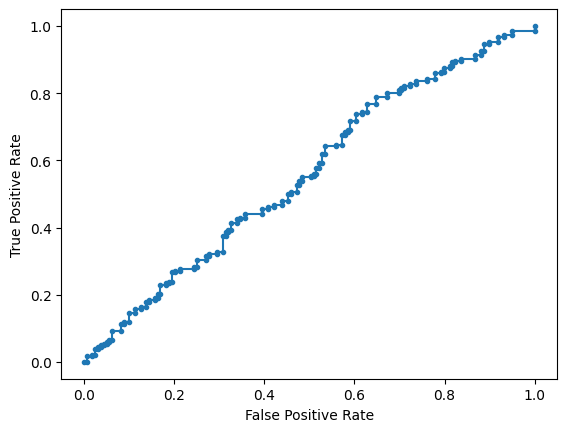

Accuracy: 55.10% Precision: 57.28% Recall: 64.13%
F1: 60.51% MCC: 0.0894
AUPRC: 57.24% AUROC: 55.80%
 accuracy [55.10204081632652]
 precision [57.28155339805825]
 recall [64.13043478260869]
 F1 [60.51282051282051]
 MCC [0.0894399928663689]
 AUPRC [57.23637923042168]
 AUROC [55.79710144927537]

Training # 2 4
2023-04-09 17:34:14.246118
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 17:34:14.580265
Discriminator ZERO -1
Train 1:0 1669:1829 47.71%
Valid 1:0 178:168 51.45%
FIT
2023-04-09 17:34:14.702699


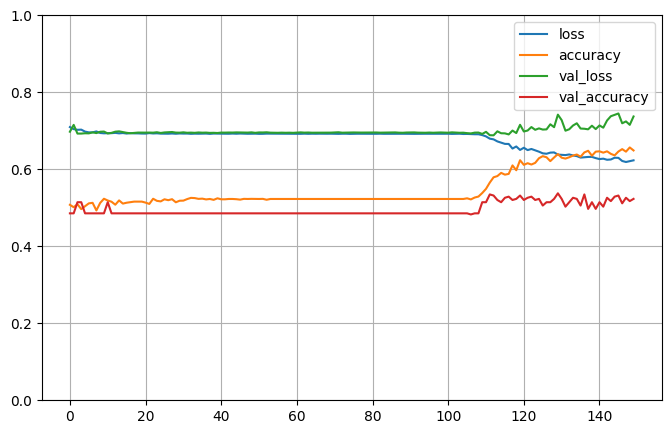


Testing # 2 4
2023-04-09 17:35:45.802684
2023-04-09 17:35:45.802741
PREDICT
2023-04-09 17:35:45.810515
Test 1:0 178:168 51.45%
Predict 1:0 115:231 33.24%
Test sizes (346, 1025) (346,)
Distrib of scores: 0.42619294 mean 0.1654865 std
Range of scores: 0.0355904 to 0.7978464
Score threshold 0.5
Confusion matrix
 [[117  51]
 [114  64]]
Normalized matrix
 [[0.33815029 0.14739884]
 [0.32947977 0.1849711 ]]
Extreme scores correct, pos:neg 19 58
Extreme scores incorrect pos:neg 16 54


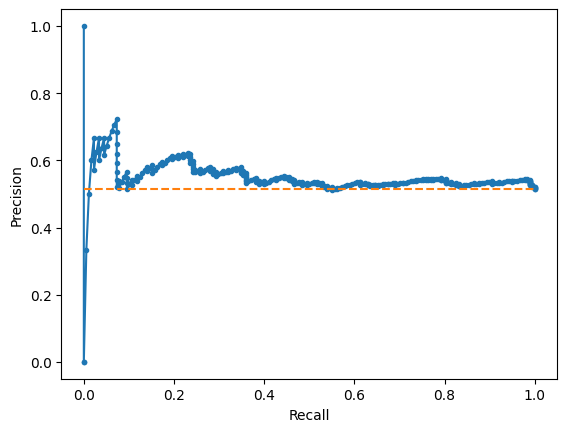

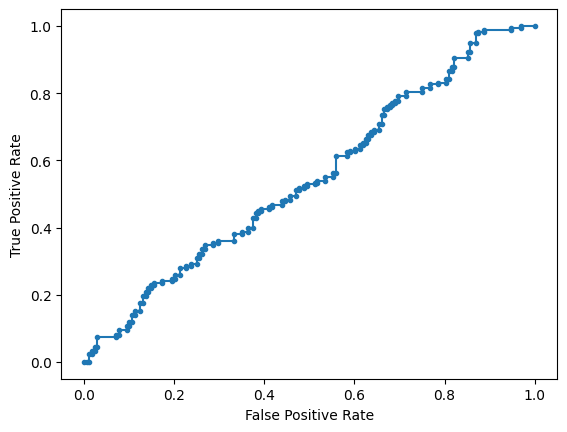

Accuracy: 52.31% Precision: 55.65% Recall: 35.96%
F1: 43.69% MCC: 0.0594
AUPRC: 54.89% AUROC: 54.64%
 accuracy [52.312138728323696]
 precision [55.65217391304348]
 recall [35.95505617977528]
 F1 [43.68600682593857]
 MCC [0.05939308739299679]
 AUPRC [54.89077663709967]
 AUROC [54.64486356340289]

Training # 2 5
2023-04-09 17:35:46.386991
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 17:35:46.716905
Discriminator ZERO -1
Train 1:0 1641:1856 46.93%
Valid 1:0 174:165 51.33%
FIT
2023-04-09 17:35:46.807020


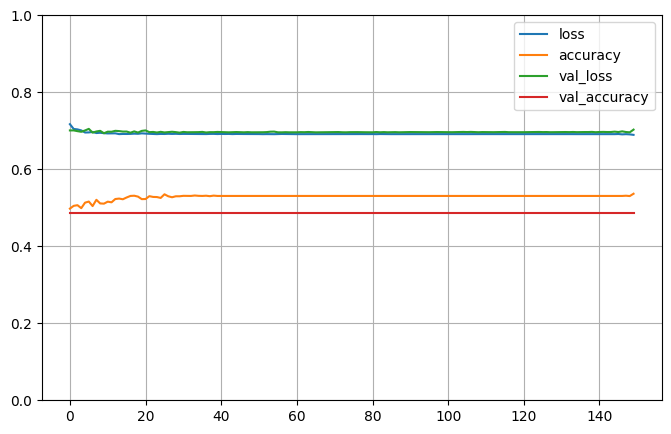


Testing # 2 5
2023-04-09 17:37:14.470999
2023-04-09 17:37:14.471051
PREDICT
2023-04-09 17:37:14.480104
Test 1:0 174:165 51.33%
Predict 1:0 0:339  0.00%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.43641892 mean 0.011892858 std
Range of scores: 0.40399376 to 0.4714627
Score threshold 0.5
Confusion matrix
 [[165   0]
 [174   0]]
Normalized matrix
 [[0.48672566 0.        ]
 [0.51327434 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


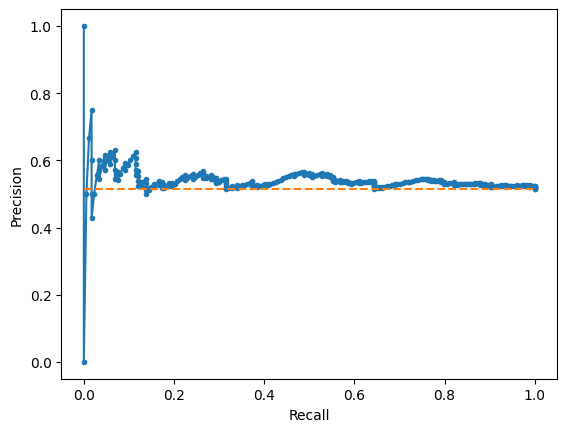

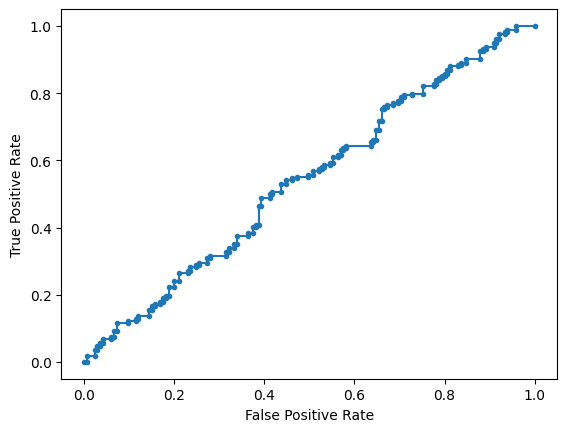

Accuracy: 48.67% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 53.92% AUROC: 54.07%
 accuracy [48.67256637168141]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [53.924180069287054]
 AUROC [54.07175200278649]
2023-04-09 17:37:15.115256


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.31% std 2.62
 precision mean 49.79% std 17.59
 recall mean 51.46% std 21.82
 F1 mean 50.08% std 18.92
 MCC mean 0.0643 std 0.0478
 AUPRC mean 56.12% std 2.96
 AUROC mean 55.51% std 2.86
 accuracy [[58.03571428571429], [52.58358662613982], [51.54929577464789], [51.25348189415042], [53.687315634218294], [54.57142857142857], [55.294117647058826], [55.10204081632652], [52.312138728323696], [48.67256637168141]]
 precision [[57.333333333333336], [55.55555555555556], [50.74626865671642], [54.054054054054056], [55.55555555555556], [55.932203389830505], [55.75221238938053], [57.28155339805825], [55.65217391304348], [0.0]]
 recall [[74.13793103448276], [59.32203389830508], [39.08045977011494], [62.17616580310881], [53.97727272727273], [55.00000000000001], [70.78651685393258], [64.13043478260869], [35.95505617977528], [0.0]]
 F1 [[64.66165413533834], [57.377049180327866], [44.15584415584416], [57.83132530120483], [54.75504322766571], [55.462184873949575], [62.376237623762364], [